In [2]:
from sklearn.datasets import fetch_lfw_pairs
from sklearn.model_selection import train_test_split

In [3]:
faces = fetch_lfw_pairs()

In [4]:
faces.DESCR

".. _labeled_faces_in_the_wild_dataset:\n\nThe Labeled Faces in the Wild face recognition dataset\n------------------------------------------------------\n\nThis dataset is a collection of JPEG pictures of famous people collected\nover the internet, all details are available on the official website:\n\n    http://vis-www.cs.umass.edu/lfw/\n\nEach picture is centered on a single face. The typical task is called\nFace Verification: given a pair of two pictures, a binary classifier\nmust predict whether the two images are from the same person.\n\nAn alternative task, Face Recognition or Face Identification is:\ngiven the picture of the face of an unknown person, identify the name\nof the person by referring to a gallery of previously seen pictures of\nidentified persons.\n\nBoth Face Verification and Face Recognition are tasks that are typically\nperformed on the output of a model trained to perform Face Detection. The\nmost popular model for Face Detection is called Viola-Jones and is\ni

In [5]:
faces.data.shape

(2200, 5828)

In [6]:
faces.pairs.shape

(2200, 2, 62, 47)

In [7]:
features = faces.pairs
target = faces.target

In [8]:
X_train, X_test, y_train,  y_test = train_test_split(features, target, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1760, 2, 62, 47), (440, 2, 62, 47), (1760,), (440,))

In [9]:
import torch
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

In [10]:
train_imgs1, train_imgs2 = torch.from_numpy(X_train[:,0]), torch.from_numpy(X_train[:,1])
test_imgs1, test_imgs2 = torch.from_numpy(X_test[:,0]), torch.from_numpy(X_test[:,1])

In [11]:
train_imgs1.shape, train_imgs2.shape, test_imgs1.shape, test_imgs2.shape

(torch.Size([1760, 62, 47]),
 torch.Size([1760, 62, 47]),
 torch.Size([440, 62, 47]),
 torch.Size([440, 62, 47]))

In [12]:
import gc
del features, target, X_train, X_test
gc.collect()

152

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import vgg11
%matplotlib inline

In [14]:
def l2_loss(a,b):
  assert a.shape ==  b.shape
  #print(len(a.shape))
  dims = tuple(range(-1, -len(a.shape), -1))
  #print(dims)
  return ((a-b)**2).sum(dims).sqrt()

In [15]:
a = torch.rand(8, 28,  28)
b = torch.rand(8, 28,  28)

loss = l2_loss(a,b)
loss, loss.shape

(tensor([11.3502, 11.5959, 11.6486, 11.3939, 11.9260, 11.6657, 11.2273, 12.0172]),
 torch.Size([8]))

In [16]:
dists = l2_loss(test_imgs1, test_imgs2)
dists.shape

torch.Size([440])

In [17]:
t = 5
preds = torch.where(dists<t, torch.zeros_like(dists), torch.ones_like(dists))

In [18]:
preds

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [19]:
def accuracy(preds, target): return (preds  == target).float().mean()
accuracy(preds, y_test)

tensor(0.4909)

In [20]:
def get_tresh(dists, target, plot=True):
  scores = []
  max_tresh = 0
  thresholds = torch.linspace(dists.min(), dists.max(), 100)
  #print(thresholds)
  for i in thresholds:
    preds = (dists>=i).int()
    scr = accuracy(preds, target)
    #print(scr)
    scores.append(scr)
    #print(scores)
    if scr>=max(scores): max_tresh = i

  if plot: plt.plot(thresholds, scores)
  return max(scores), max_tresh


(tensor(0.5068), tensor(6173.4336))

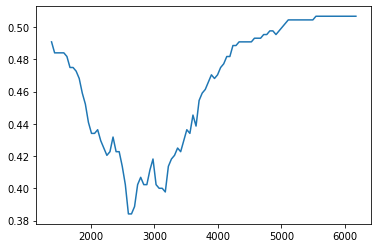

In [21]:
get_tresh(dists, y_test)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
def get_embs(imgs, model = None):
  features = []
  dl = DataLoader(imgs, batch_size=64, shuffle=False)
  model.eval()
  model.to(device)
  with torch.no_grad():
    for xb  in dl:
      feat = model(xb.to(device))
      features.append(feat)
  return torch.cat(features).view(-1, 1000)


In [28]:
def process_imgs(dataset, transforms=None):
  imgs1,  imgs2 = [], []

  for  img1, img2 in dataset:
    img1 = Image.fromarray(img1.numpy()).convert('RGB')
    img2 = Image.fromarray(img2.numpy()).convert('RGB')

    img1 = transforms(img1)
    img2 = transforms(img2)

    imgs1.append(img1)
    imgs2.append(img2)

  imgs1 = torch.stack(imgs1)
  imgs2 = torch.stack(imgs2)

  print(f'Images: {len(imgs1)} \t Images Shape: {imgs1.shape}')
  print(f'Images: {len(imgs2)} \t Images Shape: {imgs2.shape}')

  return imgs1, imgs2

In [29]:
img_sz = 224
tfms = transforms.Compose([transforms.Resize((img_sz,img_sz)),  transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [30]:
dataset = zip(test_imgs1, test_imgs2)
imgs1, imgs2 = process_imgs(dataset, transforms=tfms)

Images: 440 	 Images Shape: torch.Size([440, 3, 224, 224])
Images: 440 	 Images Shape: torch.Size([440, 3, 224, 224])


In [31]:
del dataset
gc.collect()

200

In [32]:
from torchvision.models import resnet18
model = resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [33]:
feature1 = get_embs(imgs1, model)
feature2 = get_embs(imgs2, model)

In [34]:
dists = l2_loss(feature1, feature2)
dists.shape

torch.Size([440])

(tensor(0.5068, device='cuda:0'), tensor(66.8506))

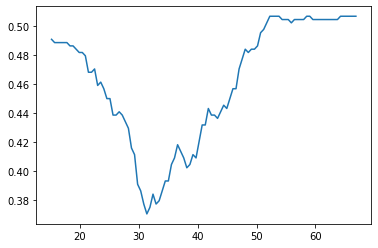

In [35]:
get_tresh(dists, y_test.to(device))

In [36]:
tfms_train = transforms.Compose([transforms.RandomHorizontalFlip(),  transforms.Resize((img_sz,img_sz)), transforms.ToTensor(),  
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

tfms_test = transforms.Compose([transforms.Resize((img_sz,img_sz)),  transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [51]:
class SimilarityDataset(Dataset):
  def __init__(self, ds, tfms):
    self.ds = ds
    self.transforms = tfms

  def __len__(self): return len(self.ds)

  def __getitem__(self, idx):
    img1, img2, label = self.ds[idx]

    img1 = Image.fromarray(img1.numpy()).convert('RGB')
    img2 = Image.fromarray(img2.numpy()).convert('RGB')

    img1 = self.transforms(img1)
    img2 = self.transforms(img2)

    return img1, img2, label.float()

In [52]:
train_ds = zip(train_imgs1, train_imgs2, y_train)
test_ds = zip(test_imgs1, test_imgs2, y_test)

In [53]:
ds_trn = SimilarityDataset(list(train_ds), tfms_train)
ds_test = SimilarityDataset(list(test_ds), tfms_test)

In [54]:
bs = 64
img_size = 224

train_dl = DataLoader(ds_trn, batch_size=bs)
test_dl = DataLoader(ds_test, batch_size=bs)

In [55]:
del train_ds, test_ds
gc.collect()

1499

In [56]:
class Siamese_Net(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.encoder = model
    self.fcl1 = nn.Linear(1000, 512)
    self.fcl2 = nn.Linear(512, 256)
    self.out = nn.Linear(256, 1)
  
  def forward(self, img1, img2):
    emb1 = self.encoder(img1)
    emb2 = self.encoder(img2)
    emb = emb1-emb2
    x = F.relu(self.fcl1(emb))
    x = F.relu(self.fcl2(x))
    return self.out(x)

In [57]:
model = Siamese_Net(resnet18(pretrained=True))
model.to(device)

Siamese_Net(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [58]:
loss_fun = nn.BCEWithLogitsLoss()

In [61]:
def train_model(epochs):
  for i in range(epochs):
    train_loss = 0.0
    model.train()
    for imgs1, imgs2, targs in train_dl:
      preds = model(imgs1.to(device), imgs2.to(device)).squeeze()
      loss = loss_fun(preds, targs.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    train_loss  /= len(train_dl)

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
      for imgs1, imgs2, targs in test_dl:
        preds = model(imgs1.to(device), imgs2.to(device)).squeeze()
        loss = loss_fun(preds, targs.to(device))
        test_loss += loss.item()
      test_loss  /= len(test_dl)

      print(f'| Epoch: {(i+1):02} | Train Loss: {train_loss:.3f} | Val. Loss:  {test_loss:.3f} |')
  



In [62]:
optimizer = optim.Adam(model.parameters(), lr = 3e-4)
train_model(5)

| Epoch: 01 | Train Loss: 0.651 | Val. Loss:  0.628 |
| Epoch: 02 | Train Loss: 0.548 | Val. Loss:  0.662 |
| Epoch: 03 | Train Loss: 0.441 | Val. Loss:  0.854 |
| Epoch: 04 | Train Loss: 0.368 | Val. Loss:  0.836 |
| Epoch: 05 | Train Loss: 0.314 | Val. Loss:  0.857 |


In [64]:
def get_preds(model):
  model.eval()
  predictions = []
  with torch.no_grad():
    for imgs1, imgs2, targs in test_dl:
      preds = model(imgs1.to(device), imgs2.to(device)).squeeze()
      predictions += list(preds)
  return torch.tensor(predictions)

(tensor(0.6636), tensor(0.3531))

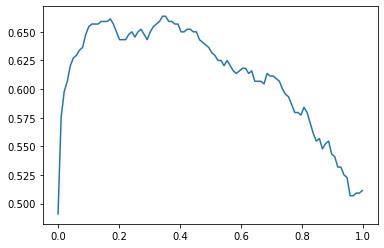

In [65]:
preds = get_preds(model)
dists = torch.sigmoid(preds)
get_tresh(dists, y_test)